In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

# full precision display
pd.set_option('display.float_format', lambda x: f"{x:.16E}")

# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
df = pd.read_csv(
    "/content/C12_final_with_tseconds (1) (1).csv",
    parse_dates=["timestamp"],
    dtype={"bias_float64": "float64", "drift_float64": "float64"}
)

df = df.sort_values("timestamp").reset_index(drop=True)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      20160 non-null  datetime64[ns]
 1   bias_float64   20160 non-null  float64       
 2   drift_float64  2016 non-null   float64       
 3   t_seconds      20160 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 630.1 KB
None
            timestamp           bias_float64          drift_float64  \
0 2024-01-14 00:00:00 7.9713159306300004E-04 4.5341061987700000E-12   
1 2024-01-14 00:00:30 7.9713124835999985E-04                    NaN   
2 2024-01-14 00:01:00 7.9713090518999984E-04                    NaN   
3 2024-01-14 00:01:30 7.9713059153999999E-04                    NaN   
4 2024-01-14 00:02:00 7.9713026537800002E-04                    NaN   

               t_seconds  
0 0.0000000000000000E+00  
1 3.0000000000000000E+01  
2 6.00000000

In [ ]:
print(df.columns.tolist())

['timestamp', 'bias_float64', 'drift_float64', 't_seconds']


In [ ]:
df["drift_float64"] = df["drift_float64"].interpolate("linear", limit_direction="both")

In [ ]:
start, end = df["timestamp"].iloc[0], df["timestamp"].iloc[-1]
idx = pd.date_range(start, end, freq="30S")

df = df.set_index("timestamp").reindex(idx)
df.index.name = "timestamp"
df = df.reset_index()

# interpolate drift only (bias untouched)
df["drift_float64"] = df["drift_float64"].interpolate("linear", limit_direction="both")

# bias should never be NaN; if missing, fill but WARN
if df["bias_float64"].isna().sum() > 0:
    print("WARNING: Missing bias detected — filling with nearest value.")
    df["bias_float64"] = df["bias_float64"].ffill().bfill()


/tmp/ipython-input-317173636.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  idx = pd.date_range(start, end, freq="30S")


In [ ]:
test_start = pd.to_datetime("2024-01-20 00:00:00")

train_df = df[df["timestamp"] < test_start].copy()
test_df  = df[df["timestamp"] >= test_start].copy()

# small validation slice from end of training
val_size = int(len(train_df) * 0.1)
val_df = train_df.iloc[-val_size:].copy()
train_df = train_df.iloc[:-val_size].copy()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_bias  = StandardScaler()
scaler_drift = StandardScaler()

scaler_bias.fit( train_df[["bias_float64"]].values )
scaler_drift.fit(train_df[["drift_float64"]].values)

def transform(df):
    Xb = scaler_bias.transform(df[["bias_float64"]].values).astype("float32")
    Xd = scaler_drift.transform(df[["drift_float64"]].values).astype("float32")
    return np.hstack([Xb, Xd])

In [ ]:
X_train_all = transform(train_df)
X_val_all   = transform(val_df)
X_test_all  = transform(test_df)

In [ ]:
def make_windows(X, window=60):
    Xs, Ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        Ys.append(X[i+window][0])  # target = scaled bias value
    return np.array(Xs), np.array(Ys)

window_size = 60  # past 30 minutes
Xtr, ytr = make_windows(X_train_all, window_size)
Xval, yval = make_windows(X_val_all, window_size)
Xte, yte = make_windows(X_test_all, window_size)

print(Xtr.shape, ytr.shape)

(15492, 60, 2) (15492,)


In [ ]:
from tensorflow.keras import layers, models

def build_gru(window, features):
    inp = layers.Input(shape=(window, features))
    x = layers.GRU(128, return_sequences=True)(inp)
    x = layers.GRU(64)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out)

model = build_gru(window_size, Xtr.shape[2])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 128)        │        50,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,049 (351.75 KB)

 Trainable params: 90,049 (351.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint("gru_best.h5", save_best_only=True)

history = model.fit(
    Xtr, ytr,
    validation_data=(Xval, yval),
    epochs=100,
    batch_size=64,
    callbacks=[es, mc],
    verbose=2
)

Epoch 1/100


243/243 - 4s - 17ms/step - loss: 0.0285 - mae: 0.0939 - val_loss: 0.0044 - val_mae: 0.0631
Epoch 2/100


243/243 - 2s - 8ms/step - loss: 0.0056 - mae: 0.0536 - val_loss: 0.0020 - val_mae: 0.0414
Epoch 3/100
243/243 - 2s - 8ms/step - loss: 0.0045 - mae: 0.0486 - val_loss: 0.0140 - val_mae: 0.1180
Epoch 4/100
243/243 - 3s - 11ms/step - loss: 0.0042 - mae: 0.0466 - val_loss: 0.0020 - val_mae: 0.0444
Epoch 5/100
243/243 - 2s - 8ms/step - loss: 0.0036 - mae: 0.0431 - val_loss: 0.0202 - val_mae: 0.1397
Epoch 6/100
243/243 - 2s - 8ms/step - loss: 0.0036 - mae: 0.0430 - val_loss: 0.0115 - val_mae: 0.1064
Epoch 7/100
243/243 - 2s - 8ms/step - loss: 0.0034 - mae: 0.0416 - val_loss: 0.0057 - val_mae: 0.0748
Epoch 8/100


243/243 - 2s - 9ms/step - loss: 0.0029 - mae: 0.0384 - val_loss: 4.4511e-04 - val_mae: 0.0194
Epoch 9/100
243/243 - 3s - 10ms/step - loss: 0.0026 - mae: 0.0365 - val_loss: 0.0027 - val_mae: 0.0513
Epoch 10/100
243/243 - 2s - 10ms/step - loss: 0.0025 - mae: 0.0363 - val_loss: 0.0317 - val_mae: 0.1773
Epoch 11/100
243/243 - 2s - 9ms/step - loss: 0.0024 - mae: 0.0359 - val_loss: 0.0120 - val_mae: 0.1093
Epoch 12/100
243/243 - 2s - 8ms/step - loss: 0.0023 - mae: 0.0350 - val_loss: 0.0101 - val_mae: 0.0991
Epoch 13/100


243/243 - 2s - 9ms/step - loss: 0.0024 - mae: 0.0360 - val_loss: 7.0198e-05 - val_mae: 0.0080
Epoch 14/100
243/243 - 2s - 8ms/step - loss: 0.0023 - mae: 0.0348 - val_loss: 0.0079 - val_mae: 0.0886
Epoch 15/100
243/243 - 3s - 12ms/step - loss: 0.0020 - mae: 0.0328 - val_loss: 0.0026 - val_mae: 0.0512
Epoch 16/100
243/243 - 2s - 8ms/step - loss: 0.0017 - mae: 0.0307 - val_loss: 0.0033 - val_mae: 0.0574
Epoch 17/100
243/243 - 2s - 8ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0033 - val_mae: 0.0570
Epoch 18/100
243/243 - 2s - 8ms/step - loss: 0.0016 - mae: 0.0293 - val_loss: 0.0138 - val_mae: 0.1173
Epoch 19/100
243/243 - 2s - 8ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 0.0133 - val_mae: 0.1155
Epoch 20/100
243/243 - 2s - 10ms/step - loss: 0.0013 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0732
Epoch 21/100
243/243 - 2s - 10ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0182 - val_mae: 0.1345
Epoch 22/100
243/243 - 2s - 8ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 0

In [ ]:
y_pred_scaled = model.predict(Xte).flatten()

y_pred = scaler_bias.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_bias.inverse_transform(yte.reshape(-1,1)).flatten()

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
out = pd.DataFrame({
    "timestamp": test_df["timestamp"].iloc[window_size: window_size+len(y_pred)].values,
    "true_bias": y_true,
    "pred_bias": y_pred
})



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # no 'squared' arg
print("MAE (s):", mae)
print("RMSE (s):", rmse)


MAE (s): 2.9915931065715995e-08
RMSE (s): 3.553480863450068e-08


In [ ]:
import os, joblib
os.makedirs("model", exist_ok=True)

joblib.dump(scaler_bias, "model/scaler_bias.pkl")
joblib.dump(scaler_drift, "model/scaler_drift.pkl")  # optional
model.save("model/gru_model.keras")


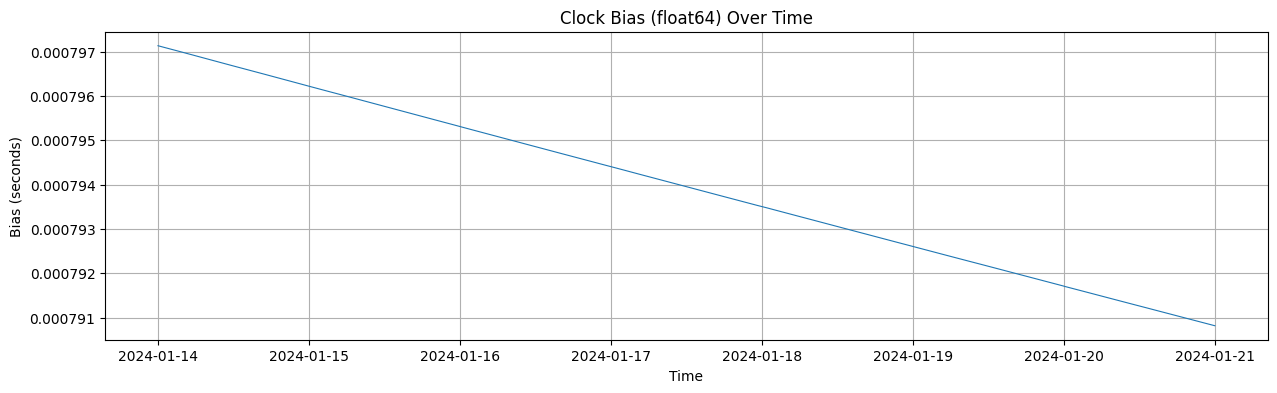

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(df["timestamp"], df["bias_float64"], linewidth=0.8)
plt.title("Clock Bias (float64) Over Time")
plt.xlabel("Time")
plt.ylabel("Bias (seconds)")
plt.grid(True)
plt.show()


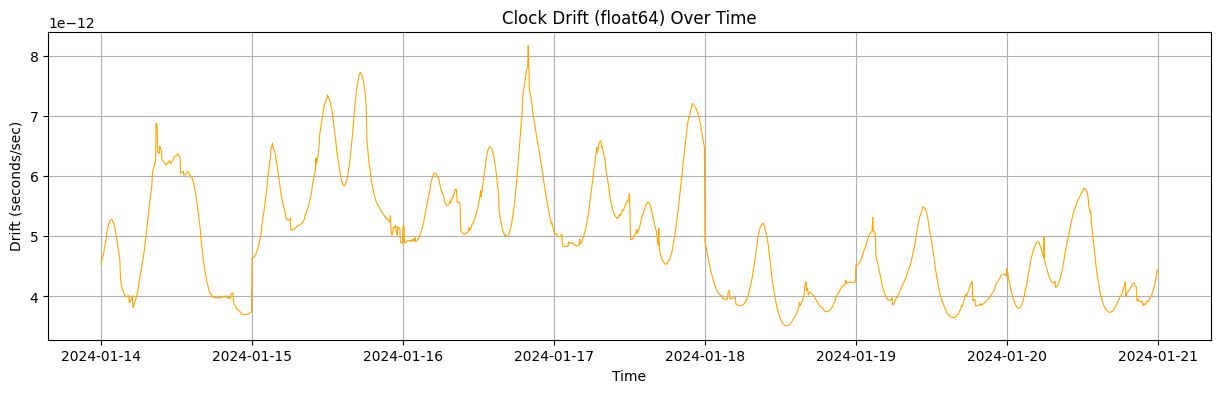

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(df["timestamp"], df["drift_float64"], linewidth=0.8, color='orange')
plt.title("Clock Drift (float64) Over Time")
plt.xlabel("Time")
plt.ylabel("Drift (seconds/sec)")
plt.grid(True)
plt.show()

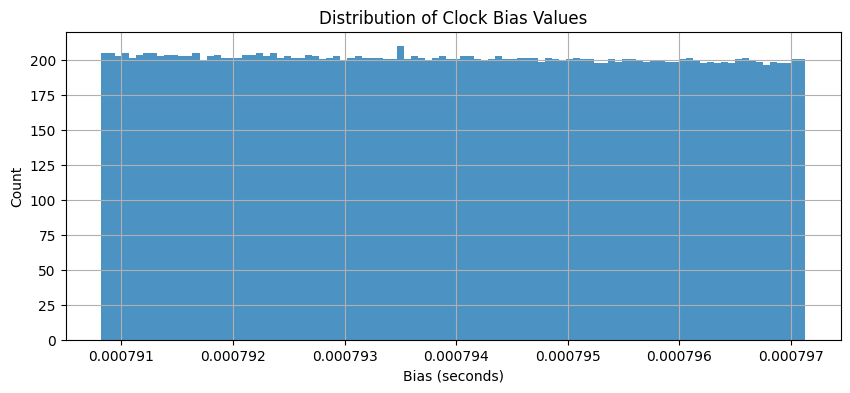

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(df["bias_float64"], bins=100, alpha=0.8)
plt.title("Distribution of Clock Bias Values")
plt.xlabel("Bias (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

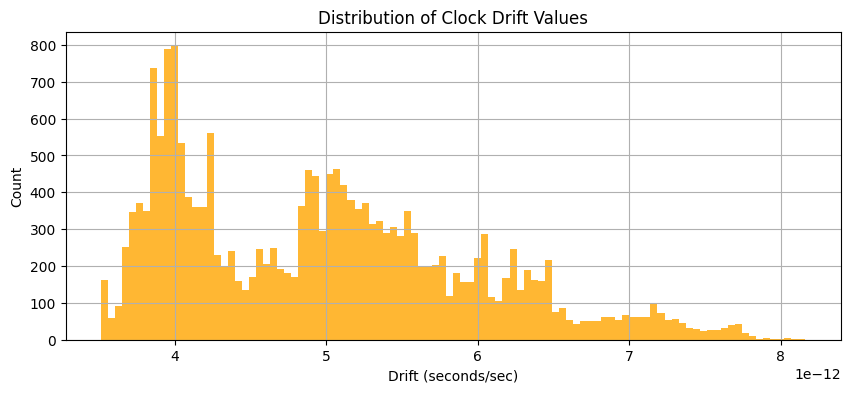

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(df["drift_float64"], bins=100, color="orange", alpha=0.8)
plt.title("Distribution of Clock Drift Values")
plt.xlabel("Drift (seconds/sec)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

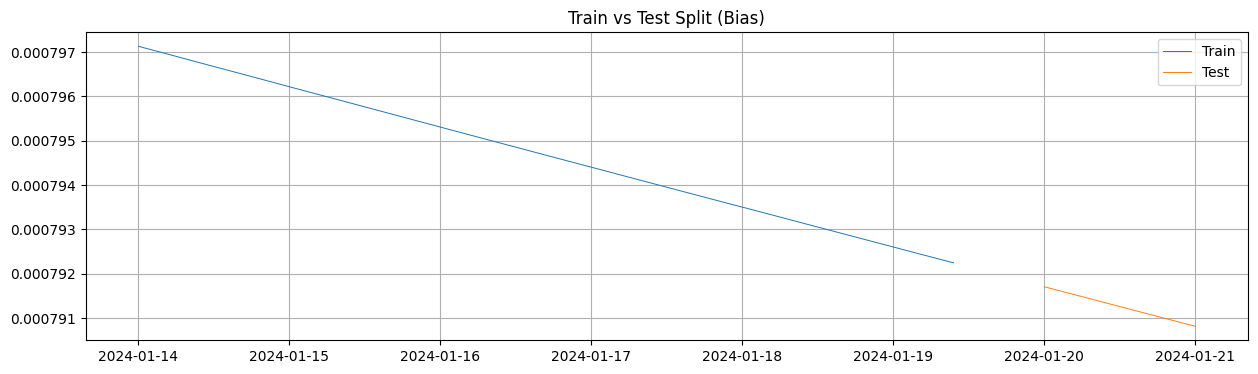

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(train_df["timestamp"], train_df["bias_float64"], label="Train", linewidth=0.7)
plt.plot(test_df["timestamp"], test_df["bias_float64"], label="Test", linewidth=0.7)
plt.title("Train vs Test Split (Bias)")
plt.legend()
plt.grid(True)
plt.show()

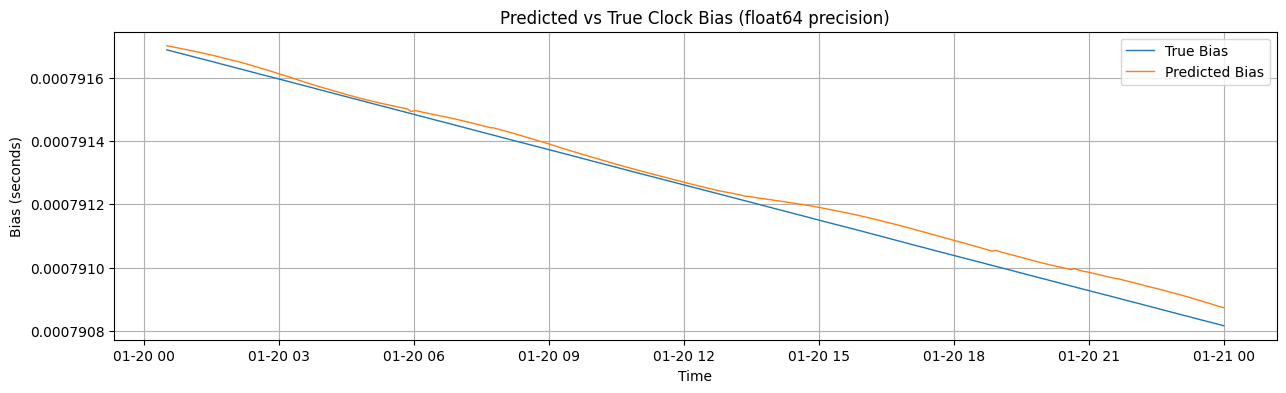

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(out["timestamp"], out["true_bias"], label="True Bias", linewidth=1)
plt.plot(out["timestamp"], out["pred_bias"], label="Predicted Bias", linewidth=1)
plt.title("Predicted vs True Clock Bias (float64 precision)")
plt.xlabel("Time")
plt.ylabel("Bias (seconds)")
plt.legend()
plt.grid(True)
plt.show()

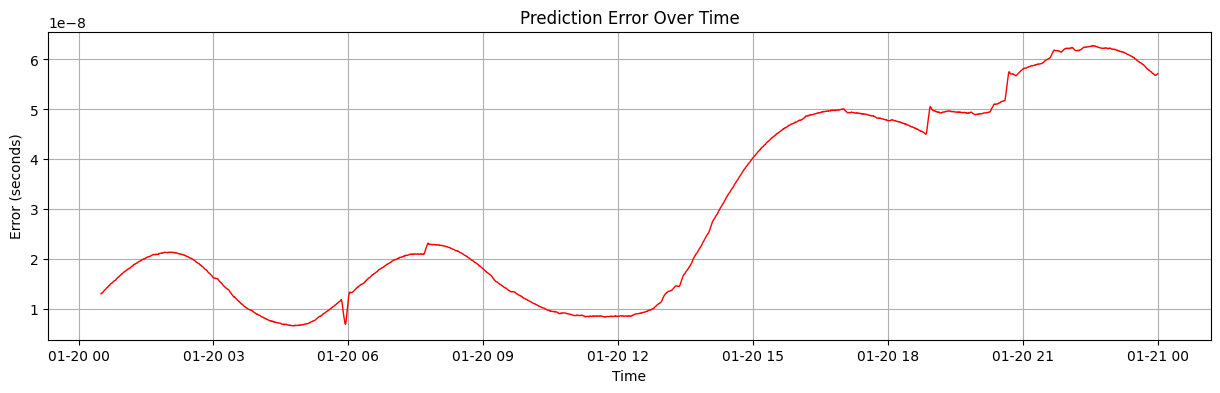

In [ ]:
out["error"] = out["pred_bias"] - out["true_bias"]

plt.figure(figsize=(15,4))
plt.plot(out["timestamp"], out["error"], linewidth=1, color='red')
plt.title("Prediction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Error (seconds)")
plt.grid(True)
plt.show()

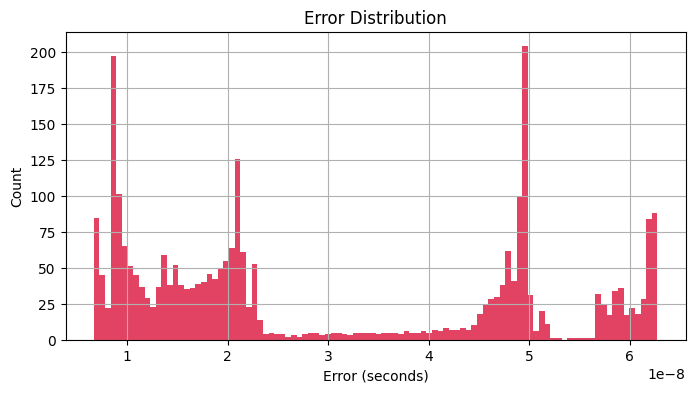

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(out["error"], bins=100, color='crimson', alpha=0.8)
plt.title("Error Distribution")
plt.xlabel("Error (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

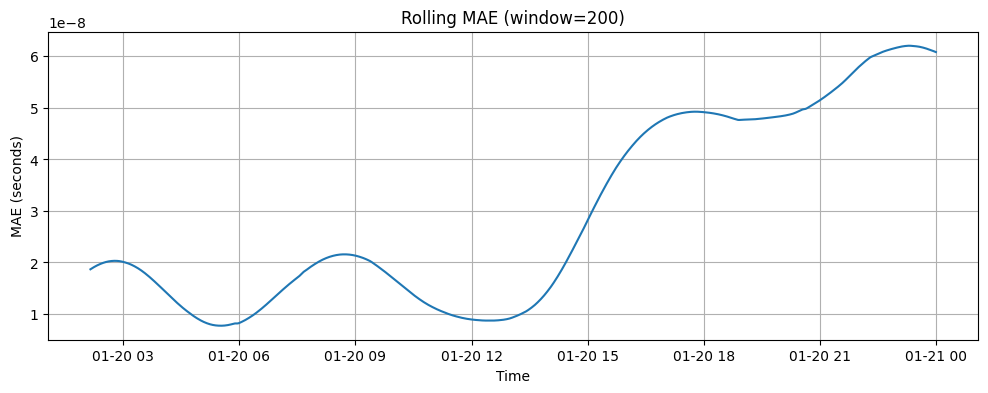

In [ ]:
import numpy as np

window = 200   # adjust

rolling_mae = np.abs(out["error"]).rolling(window).mean()

plt.figure(figsize=(12,4))
plt.plot(out["timestamp"], rolling_mae)
plt.title(f"Rolling MAE (window={window})")
plt.xlabel("Time")
plt.ylabel("MAE (seconds)")
plt.grid(True)
plt.show()

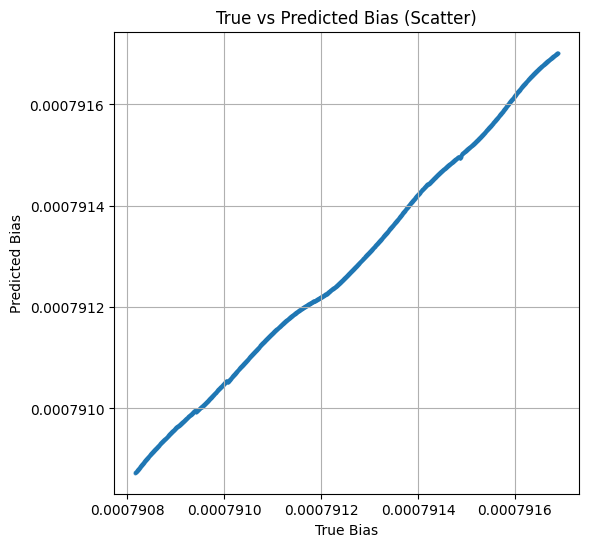

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(out["true_bias"], out["pred_bias"], s=3, alpha=0.5)
plt.title("True vs Predicted Bias (Scatter)")
plt.xlabel("True Bias")
plt.ylabel("Predicted Bias")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [ ]:
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
r, _ = pearsonr(y_true, y_pred)

print("=== FULL PRECISION METRICS ===")
print(f"MAE  : {mae:.16E}")
print(f"MSE  : {mse:.16E}")
print(f"RMSE : {rmse:.16E}")
print(f"R^2  : {r2:.16f}")
print(f"r    : {r:.16f}")

=== FULL PRECISION METRICS ===
MAE  : 2.9915931065715995E-08
MSE  : 1.2627226246905840E-15
RMSE : 3.5534808634500680E-08
R^2  : 0.9801413416862488
r    : 0.9991033673286438
